In [29]:
import os
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import cv2
from collections import Counter
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [2]:
folder_path = '/kaggle/input/frames-10fps/frames'  # Replace with your folder path
folders=sorted(os.listdir(folder_path))

In [3]:
paths=[]
for i in tqdm(range(len(folders))):
    files=os.listdir(os.path.join(folder_path,folders[i]))
    files.sort(key=lambda x: int(x.split('.')[0]))
    files=[os.path.join(folder_path,folders[i],files[j]) for j in range(len(files))]
    paths=paths+files

100%|██████████| 27/27 [00:14<00:00,  1.89it/s]


In [4]:
def get_csv_id(file_path):

    # Extract the filename without extension
    filename = os.path.basename(file_path)  # RightVideoSN001.csv

    # Extract the identifier ('1' or '11')
    if filename.startswith('RightVideoSN'):
        identifier = filename[len('RightVideoSN'):]  # Get '001' or '011'
        identifier = identifier.lstrip('0').split('.')[0]  # Remove leading zeros

    return int(identifier)
def get_id(path):

    # Split the path by '/'
    parts = path.split('/')

    # Get the directory name that contains the image
    dirname = parts[-2]  # RightVideoSN011

    # Extract the relevant parts from the directory name
    if dirname.startswith('RightVideoSN'):
        identifier = dirname[len('RightVideoSN'):]  # Get SN011 -> 011
        identifier = identifier.lstrip('0')  # Remove leading zeros

    # Get the image number from the filename
    filename = parts[-1]  # 240.jpg
    image_number = os.path.splitext(filename)[0]  # 240

    return int(identifier),int(image_number)

In [5]:
folder_path = '/kaggle/input/labels-csv/labels_csv'
csv_path=[]
for root, dirs, files in os.walk(folder_path):
    for file_name in files:
        file_path = os.path.join(root, file_name)
        csv_path.append(file_path)
csv_path=sorted(csv_path)
csv={}
for file in csv_path:
    df=pd.read_csv(file)
    ide=get_csv_id(file)
    csv[ide]=df

In [6]:
col=csv[1].columns
col

Index(['au1', 'au12', 'au15', 'au17', 'au2', 'au20', 'au25', 'au26', 'au4',
       'au5', 'au6', 'au9'],
      dtype='object')

In [7]:
labels=[]
for file in tqdm(paths):
    ide,image=get_id(file)
    try:
        label=np.array(csv[ide].iloc[image])
        label[label > 0]=1
        labels.append(label)
    except IndexError as e:
        print(f"IndexError occurred: {ide}")
        print(f"Check ide={ide} and image={image} against csv indices.")
labels=np.array(labels)

100%|██████████| 65420/65420 [00:05<00:00, 13025.31it/s]


In [8]:
for i in range(12):
    print(Counter(labels[:,i]))

Counter({0: 61029, 1: 4391})
Counter({0: 50006, 1: 15414})
Counter({0: 61491, 1: 3929})
Counter({0: 58968, 1: 6452})
Counter({0: 61736, 1: 3684})
Counter({0: 63151, 1: 2269})
Counter({0: 42389, 1: 23031})
Counter({0: 52931, 1: 12489})
Counter({0: 53121, 1: 12299})
Counter({0: 64053, 1: 1367})
Counter({0: 55670, 1: 9750})
Counter({0: 61855, 1: 3565})


In [9]:
zero_indices = np.where(~labels.any(axis=1))[0]
nz=np.where(labels.any(axis=1))[0]
print("Indices where all elements in rows are zero:",len(zero_indices))
print("Indices where all elements in rows are all not  zero:",len(nz))

Indices where all elements in rows are zero: 24304
Indices where all elements in rows are all not  zero: 41116


In [10]:
random_numbers = np.random.choice(zero_indices, size=4000, replace=False)
mask=np.concatenate((random_numbers,nz))
mask.sort()

In [11]:
sam_labels=labels[mask]
sam_labels.shape

(45116, 12)

In [12]:
frames=[]
target_size=(224, 224)
for i in tqdm(range(len(paths))):
    if i in mask:
        img=cv2.imread(paths[i],0)
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        rgb_image = cv2.cvtColor(resized_img, cv2.COLOR_GRAY2RGB)
        frames.append(rgb_image)

100%|██████████| 65420/65420 [06:15<00:00, 174.27it/s]


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(frames),sam_labels,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((36092, 224, 224, 3), (9024, 224, 224, 3), (36092, 12), (9024, 12))

In [14]:
from tensorflow.keras.metrics import AUC
pr_metric = AUC(curve='PR', num_thresholds=1000)

import tensorflow as tf
from sklearn.metrics import average_precision_score

def sk_pr_auc(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)


2024-07-11 05:57:21.783853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 05:57:21.783971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 05:57:21.906511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        # Define epsilon to avoid log(0)
        epsilon = tf.keras.backend.epsilon()
        # Clip predictions to prevent log(0) and log(1 - 0)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        # Compute the focal loss
        fl = - alpha * (y_true * (1 - y_pred)**gamma * tf.math.log(y_pred)
                       + (1 - y_true) * (y_pred**gamma) * tf.math.log(1 - y_pred))
        return tf.reduce_mean(fl, axis=-1)
    return focal_loss

loss = binary_focal_loss(gamma=2.0, alpha=0.25)

In [ ]:
model = tf.keras.models.load_model('/kaggle/input/incpert/incept_v3_10fps_full_dp0.4.keras',
                                       custom_objects={'binary_focal_loss': binary_focal_loss})

In [51]:
preds=model.predict(X_test)

282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step


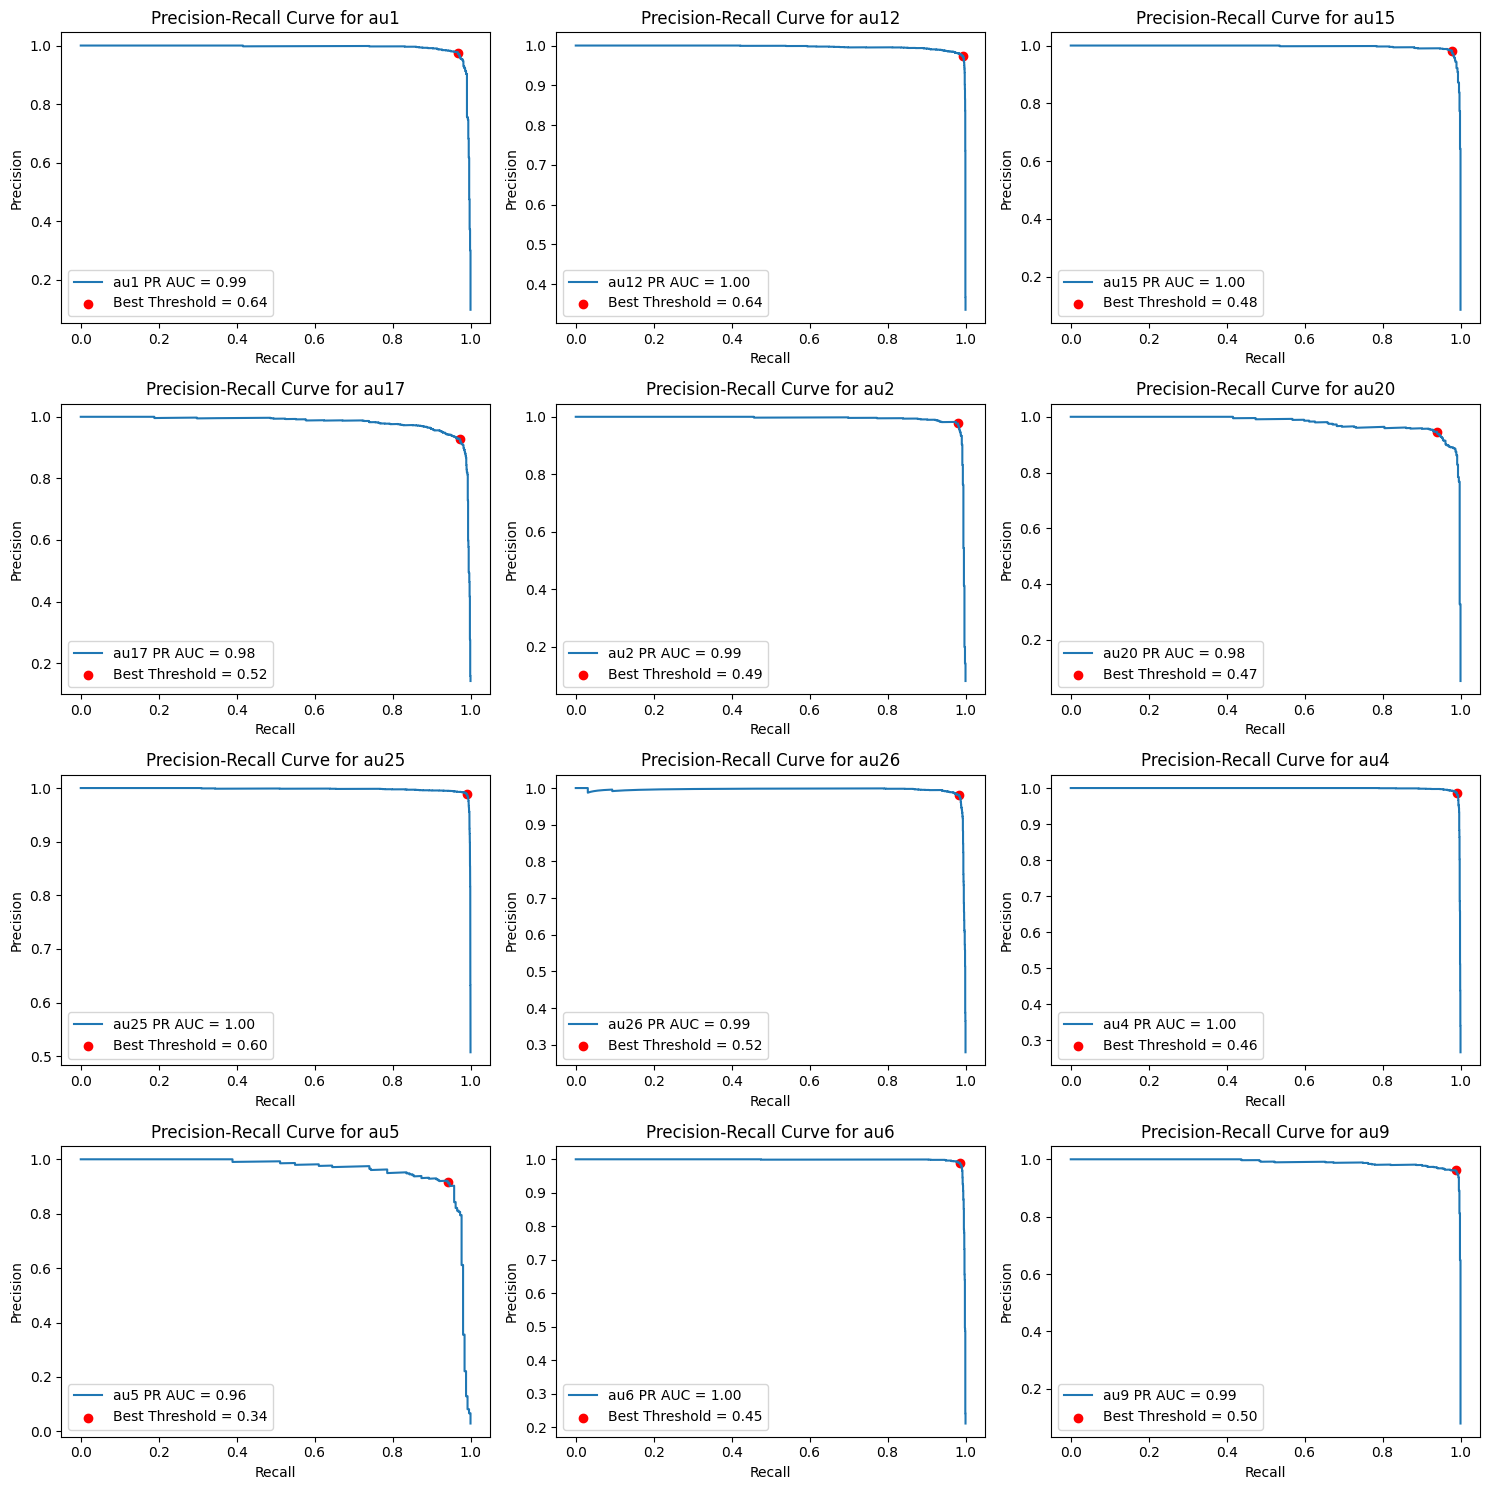

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Assuming y_test contains the true binary labels and pred contains the predicted probabilities
# au contains the names of the action units or labels
au = csv[1].columns
t=[]
# Create a figure and a grid of subplots (4x3)
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easier indexing

# Loop through each label
for i in range(12):
    # Compute precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test[:, i], preds[:, i])

    # Calculate the precision-recall AUC
    pr_auc = auc(recall, precision)

    # Compute F1 scores for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the threshold that maximizes the F1 score
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    t.append(best_threshold)
    best_f1 = f1_scores[best_threshold_index]

    # Plot the precision-recall curve
    ax = axes[i]
    ax.plot(recall, precision, label=f'{au[i]} PR AUC = {pr_auc:.2f}')
    ax.scatter(recall[best_threshold_index], precision[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve for {au[i]}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [28]:
y_pred = (preds >= t).astype(int)

Accuracy of each action unit 
au1   :  0.9925753546099291
au12   :  0.9848182624113475
au15   :  0.996343085106383
au17   :  0.9840425531914894
au2   :  0.9962322695035462
au20   :  0.9939051418439716
au25   :  0.9891400709219859
au26   :  0.9893617021276596
au4   :  0.993572695035461
au5   :  0.9942375886524822
au6   :  0.9942375886524822
au9   :  0.9957890070921985


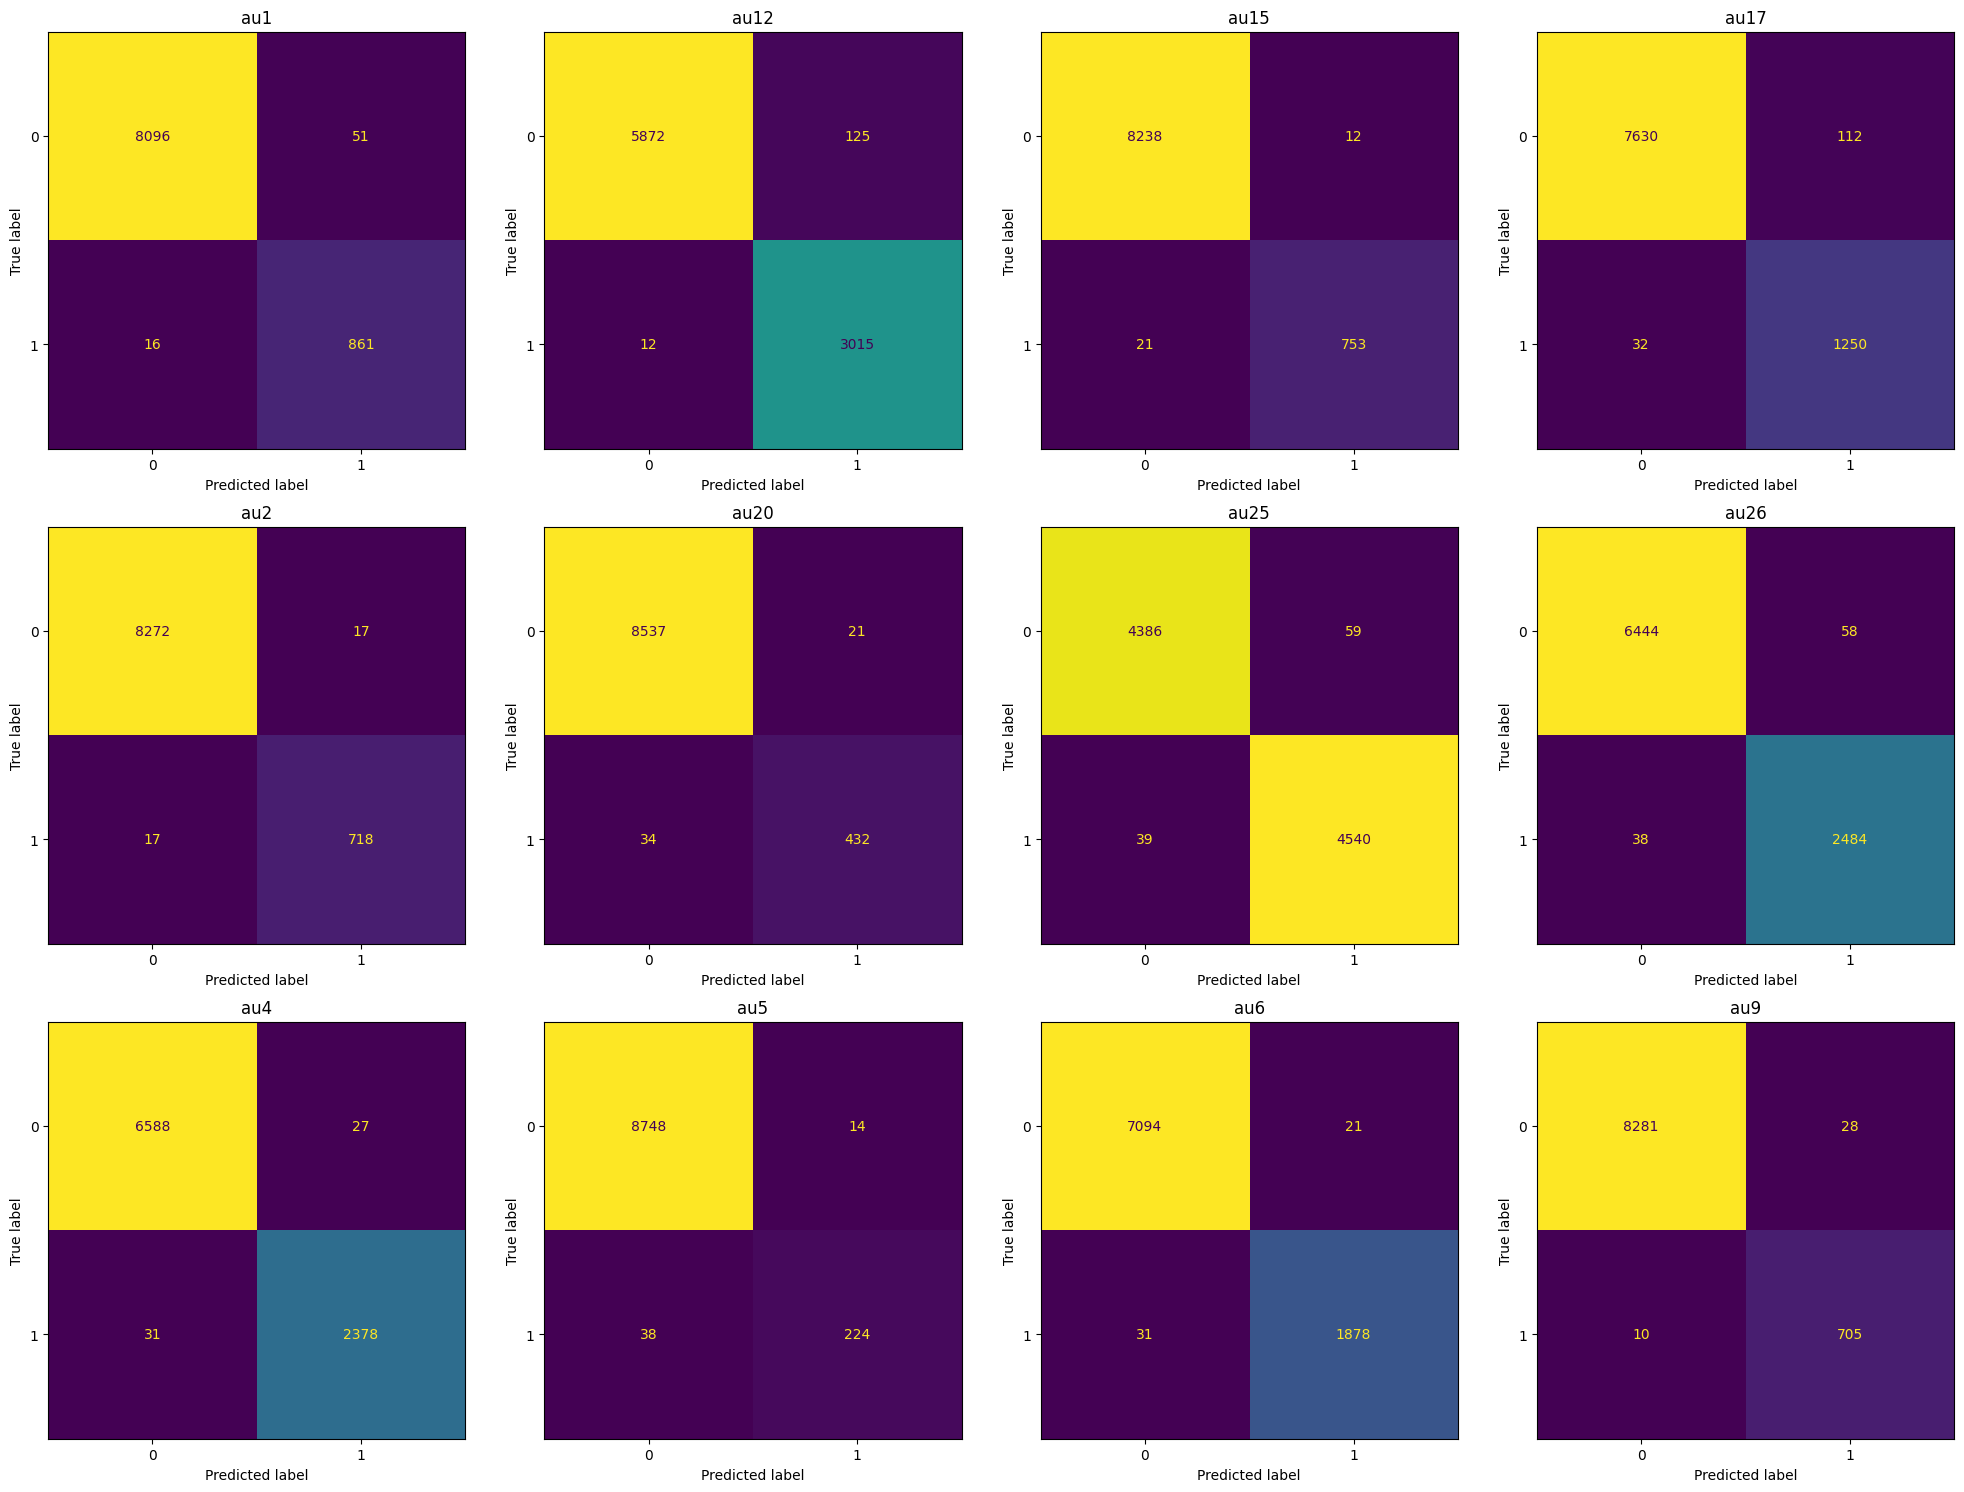

In [41]:

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()
p=preds.round()
print("Accuracy of each action unit ")

for i in range(12):
    print(f'{au[i] }   : ', accuracy_score(y_test[:, i], p[:, i]))
for i in range(12):
    cm = confusion_matrix(y_test[:, i], p[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(au[i])

# Adjust layout
plt.tight_layout()
plt.show()

Accuracy of each action unit 
au1   :  0.9945700354609929
au12   :  0.9886968085106383
au15   :  0.9965647163120568
au17   :  0.9853723404255319
au2   :  0.9965647163120568
au20   :  0.9941267730496454
au25   :  0.9896941489361702
au26   :  0.989915780141844
au4   :  0.9939051418439716
au5   :  0.9958998226950354
au6   :  0.994459219858156
au9   :  0.9958998226950354


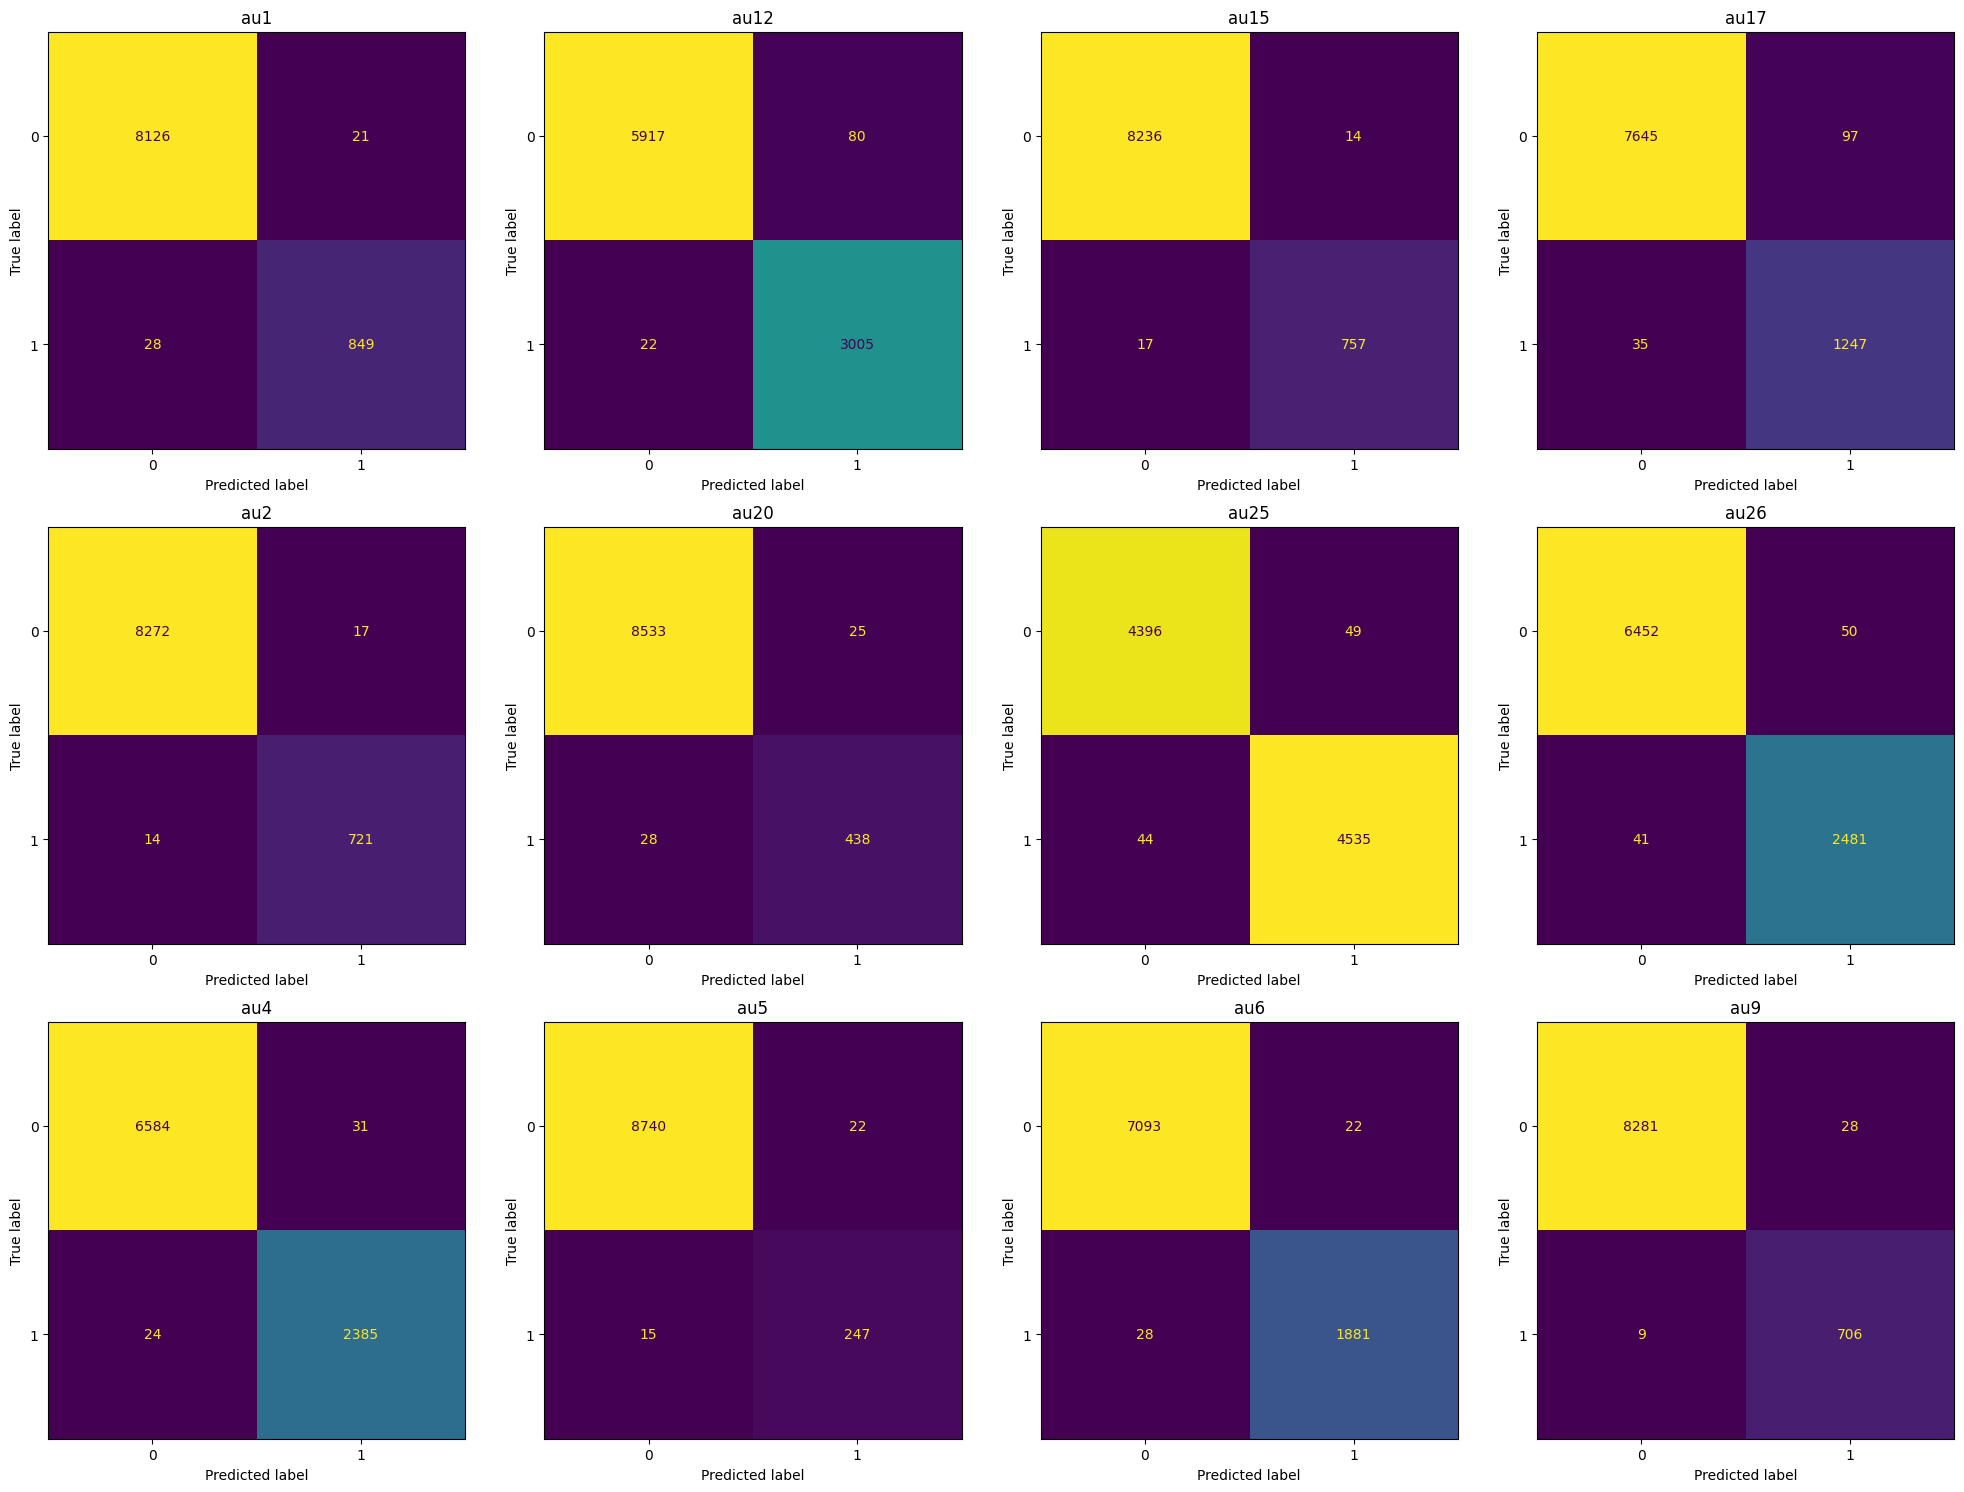

In [40]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()
print("Accuracy of each action unit ")
for i in range(12):
    print(f'{au[i]}   : ', accuracy_score(y_test[:, i], y_pred[:, i]))
for i in range(12):
    cm = confusion_matrix(y_test[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(au[i])

# Adjust layout
plt.tight_layout()
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
0.63804066


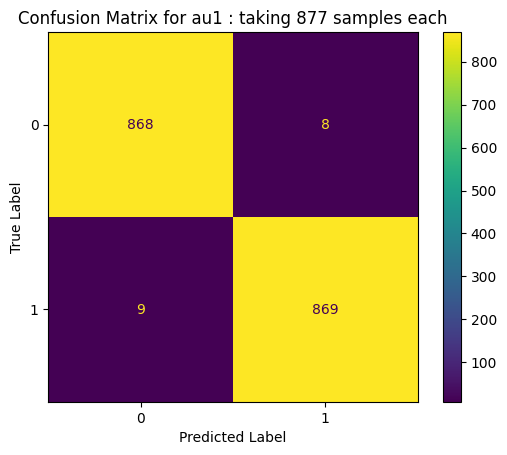

190/190 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step
0.6402501


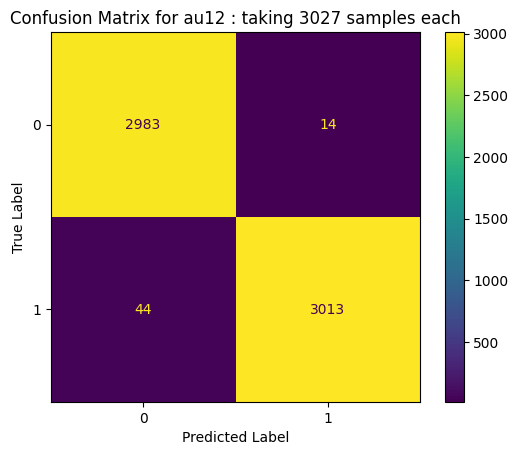

 5/49 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step

KeyboardInterrupt: 

In [54]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report 
import matplotlib.pyplot as plt
np.random.seed(0)
th=[]
for i in range(12):
    zero_indices = np.where(y_test[:,i] == 0)[0]
    one_indices = np.where(y_test[:,i] == 1)[0]
    sam=min(len(one_indices),len(zero_indices))
    zero_samples = np.random.choice(zero_indices, sam, replace=False)
    mask=np.concatenate((zero_samples,one_indices))
    test=X_test[mask]
    real=y_test[mask]
    preds=model.predict(test)
    precision, recall, thresholds = precision_recall_curve(real[:,i], preds[:,i])

    # Compute F1 scores for the thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the index of the best F1 score
    best_index = np.argmax(f1_scores[:-1])
    best_threshold = thresholds[best_index]
    th.append(best_threshold)
    y_pred = (preds[:,i] >= best_threshold).astype(int)
    print(t[i])
    cm = confusion_matrix(y_pred, real[:,i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix for {col[i]} : taking {sam} samples each")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


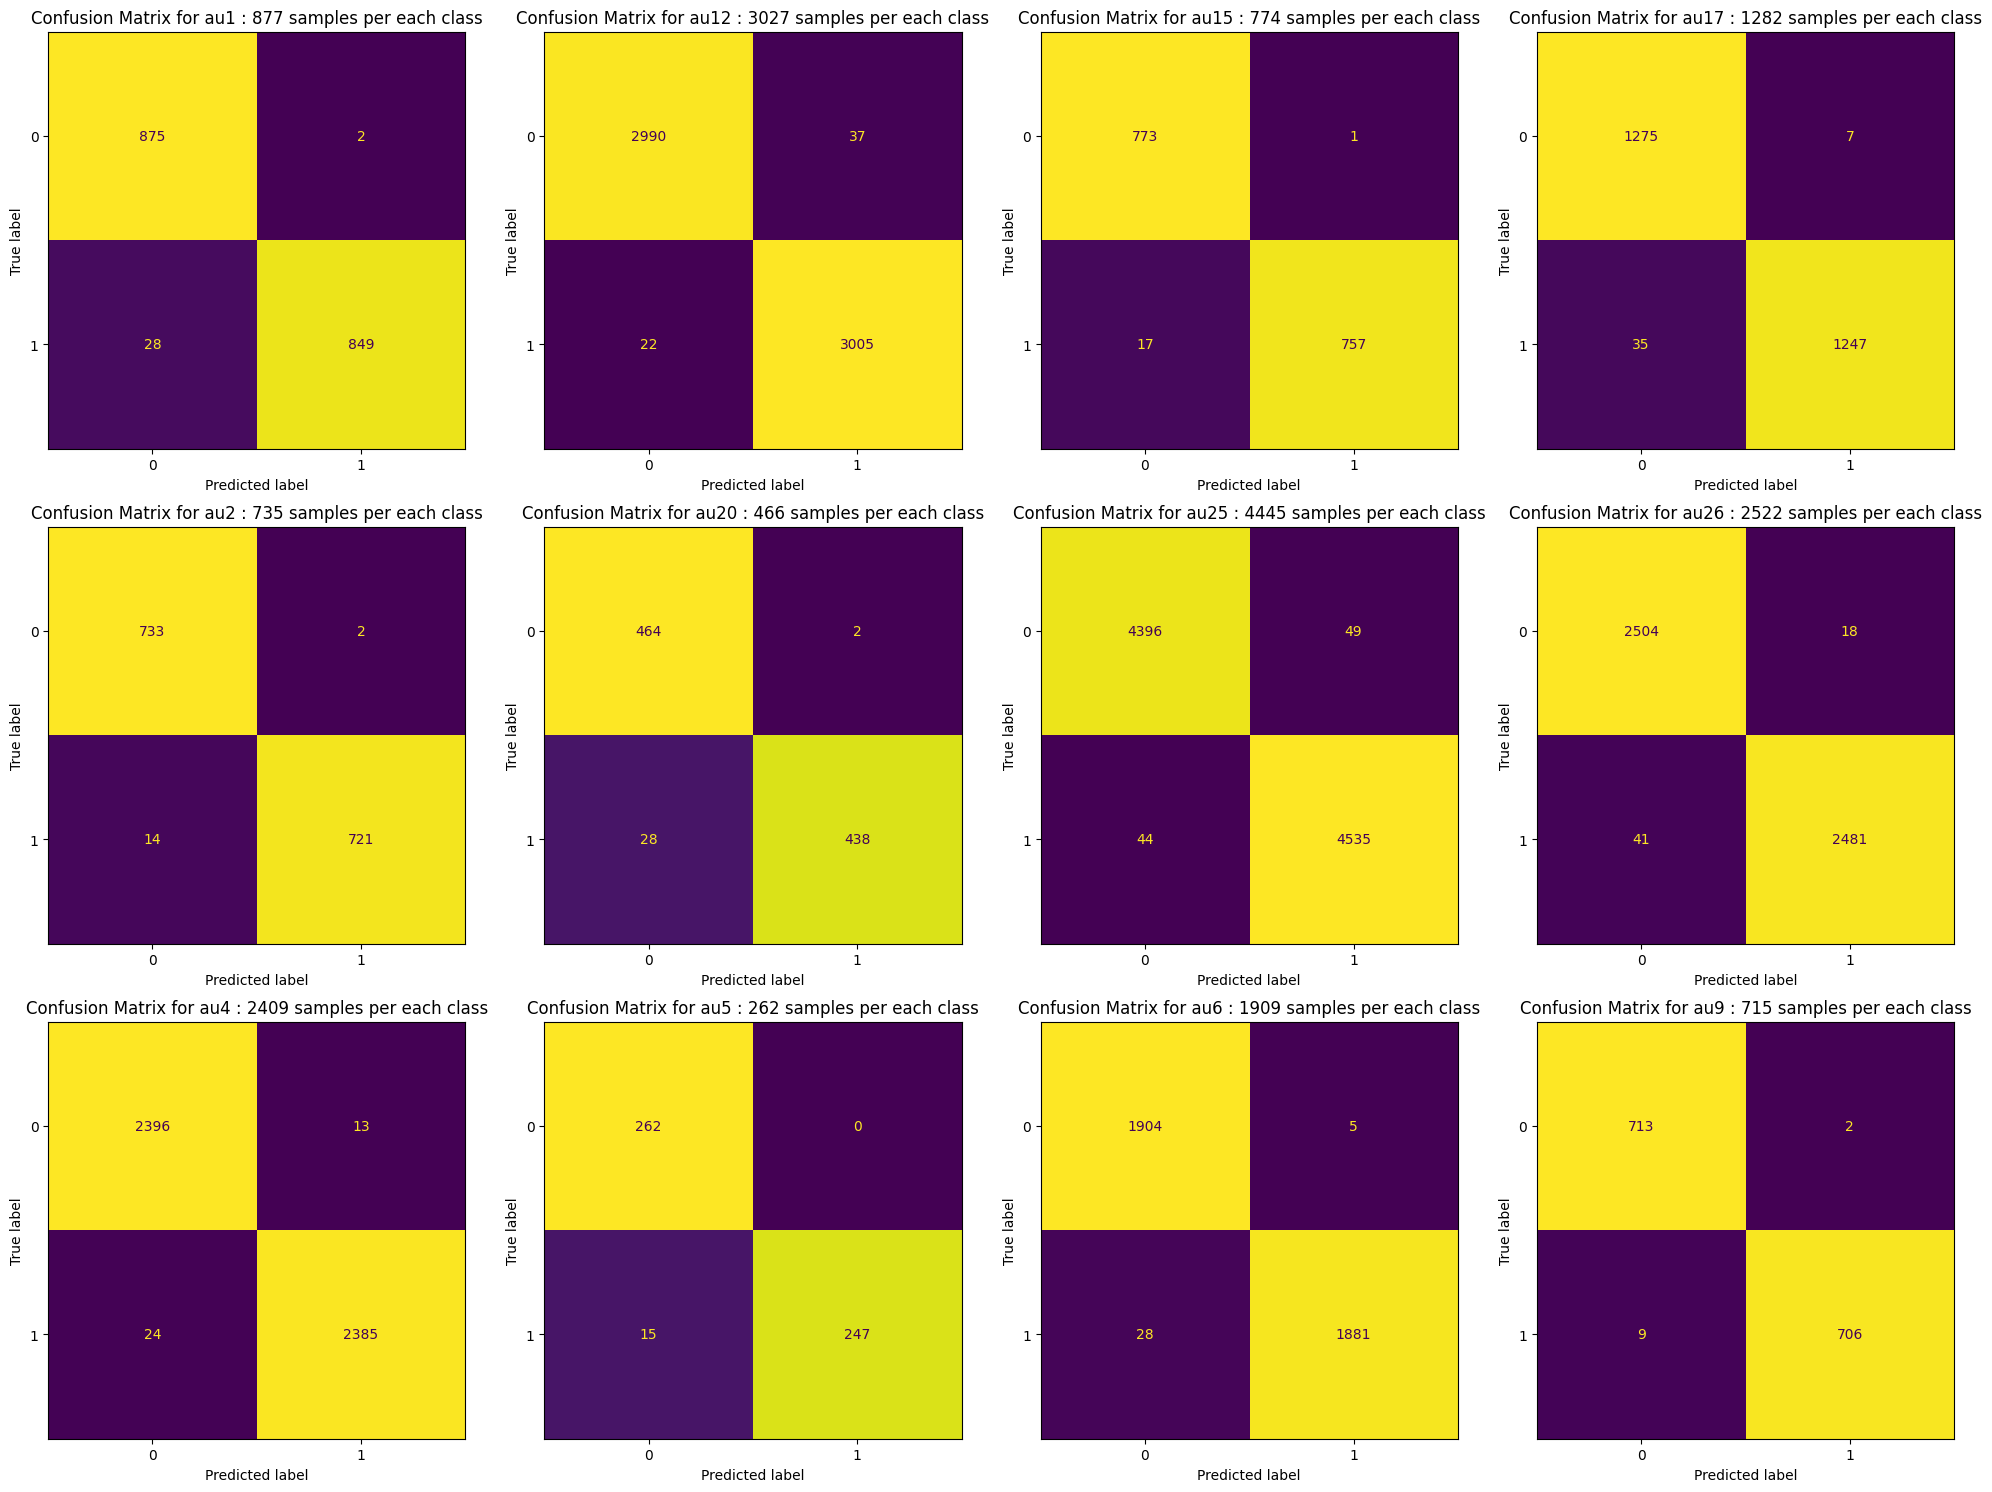